# Comparing the percentage of English Language Learners and Students with First Language Not English between Charter and Public Schools in Massachusetts

## The Question

In this notebook, we will examine whether or not charter schools in Massachusetts significantly differ from public schools in terms of the number of students with English as a second language they serve. My hypothesis is that there is a difference and that charter schools underserve these students relative to their neighboring public schools.

In [2]:
# import packages
from scipy.stats import ttest_ind, ttest_ind_from_stats
from statsmodels.stats.proportion import proportions_ztest
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import numpy as np

# set jupyter netbook options
pd.set_option('max_columns',0)
%matplotlib inline

In [4]:
# read data from Mass DOE
schools = pd.read_csv('MA_Public_Schools_2017.csv')
schools.dropna(inplace=True, subset=['First Language Not English', 'English Language Learner'])

# select columns relevant to English Language Learners
school_ell = schools[['School Code','School Name','School Type','District Name','District Code','Zip',
                      'TOTAL_Enrollment', 'First Language Not English', '% First Language Not English', 
                      'English Language Learner', '% English Language Learner']]

school_ell.head()

,School Code,School Name,School Type,District Name,District Code,Zip,TOTAL_Enrollment,First Language Not English,% First Language Not English,English Language Learner,% English Language Learner
0,10505,Abington High,Public School,Abington,10000,2351,452,24.0,5.3,11.0,2.4
1,10003,Beaver Brook Elementary School,Public School,Abington,10000,2351,580,61.0,10.5,42.0,7.2
2,10002,Center Elementary School,Public School,Abington,10000,2351,203,26.0,12.8,6.0,3.0
3,10405,Frolio Middle School,Public School,Abington,10000,2351,328,18.0,5.5,6.0,1.8
4,10015,Woodsdale Elementary School,Public School,Abington,10000,2351,353,21.0,5.9,7.0,2.0


## Initial Observation

By pivoting on the type of school in our data, it appears that across the state of Massachusetts charter schools have significantly higher proportions of both English language learners and students with English as a second language.

In [5]:
school_ell.pivot_table(index = 'School Type', 
                       values=['First Language Not English', '% First Language Not English',
                               'English Language Learner', '% English Language Learner'],
                       aggfunc={'First Language Not English':'sum', '% First Language Not English':'mean',
                                'English Language Learner':'sum', '% English Language Learner':'mean'})

,% English Language Learner,% First Language Not English,English Language Learner,First Language Not English
School Type,,,,
Charter School,13.051282,26.371795,5482.0,12545.0
Public School,9.394244,18.203894,84722.0,179419.0


By visually comparing the distributions of percentages of English language learners, we can check to see if there are any outliers skewing the data and whether or not charter and public schools have similar distributions. After creating the histogram below, we see that in fact both charter and public schools have different distributions. It appears that charter schools would have an average percentage of English language learners that is skewed more to the right than that of public schools.

By doing a two sample t-test on the average percentage of English language learners in a school, we find with a p-value below 0.05 that there is a significant difference between charter and public schools on average.

In [6]:
charter_ell = schools[schools['School Type'] == 'Charter School']['% English Language Learner']
public_ell  = schools[schools['School Type'] == 'Public School']['% English Language Learner']

print('Charter mean: {:.2f}  Public mean: {:.2f}'.format(charter_ell.mean(), public_ell.mean()))

ttest_ind(charter_ell, public_ell)

Charter mean: 13.05  Public mean: 9.39


Ttest_indResult(statistic=2.4045043704771123, pvalue=0.0162922541540307)

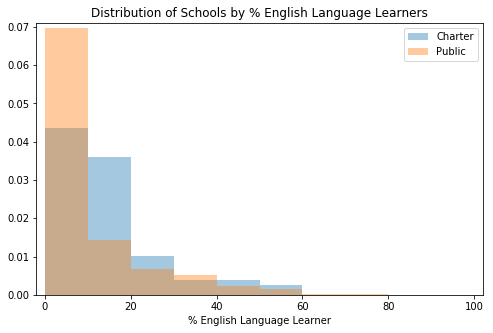

In [7]:
bins = [10*i for i in range(0,11)]

plt.figure(figsize=(8,5))
sns.distplot(charter_ell, bins=bins, kde=False, norm_hist=True)
sns.distplot(public_ell, bins=bins, kde=False, norm_hist=True)
plt.title('Distribution of Schools by % English Language Learners')
plt.margins(0.02)
plt.legend(['Charter', 'Public'])

By performing a similar analysis for the percentage of students with first language not English, we obtain similar results. With a p-value well below 0.05, we see that there is an even more significant difference between charter and public schools when it comes to students with English as a second language.

In [48]:
charter_flne = schools[schools['School Type'] == 'Charter School']['% First Language Not English']
public_flne  = schools[schools['School Type'] == 'Public School']['% First Language Not English']

print('Charter mean: {:.2f}  Public mean: {:.2f}'.format(charter_flne.mean(), public_flne.mean()))

ttest_ind(charter_flne, public_flne)

Charter mean: 26.37  Public mean: 18.20


Ttest_indResult(statistic=3.5354653107637515, pvalue=0.00041708326560901466)

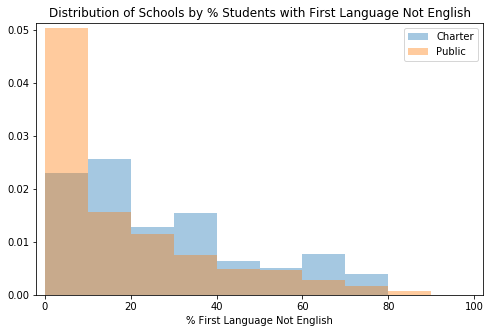

In [49]:
bins = [10*i for i in range(0,11)]

plt.figure(figsize=(8,5))
sns.distplot(charter_flne, bins=bins, kde=False, norm_hist=True)
sns.distplot(public_flne, bins=bins, kde=False, norm_hist=True)
plt.title('Distribution of Schools by % Students with First Language Not English')
plt.margins(0.02)
plt.legend(['Charter', 'Public'])

## Diving deeper by zip code

One thing that the above analysis does not account for is that Massachusetts is a fairly diverse state with local populations varying based on location and urbanization. To get a better sense of how charter schools are serving these students it would help to focus on neighboring schools and whether or not they are serving students in the same way.

To do this, we group the schools by zip code and school type so we can compare charter and public schools within the same zip code.

In [8]:
f= {'TOTAL_Enrollment':'sum', 'First Language Not English':'sum', '% First Language Not English':'mean', 
    'English Language Learner':'sum', '% English Language Learner':'mean'}

school_ell_by_zip = school_ell.drop(['School Code', 'School Name', 'District Name', 'District Code'], axis=1).groupby(['Zip', 'School Type']).agg(f)

# slice demographic data by zip codes with public and charter schools
idx = pd.IndexSlice
public_and_charter = [i for i in school_ell['Zip'] if len(school_ell_by_zip.loc[idx[i]]) == 2]
school_ell_compare = school_ell_by_zip.loc[idx[public_and_charter]].copy()

In [9]:
school_ell_compare.head(6)

TOTAL_Enrollment             ...              % English Language Learner
Zip  School Type                                  ...                                        
1022 Charter School               478             ...                                4.600000
     Public School                366             ...                                0.000000
1027 Charter School               218             ...                                0.000000
     Public School               2433             ...                                2.214286
1035 Charter School               471             ...                                2.500000
     Public School                562             ...                                1.600000

[6 rows x 5 columns]

Now, we will perform the same analysis that we did for the entire state of Massachusetts. However, because we've lost some information (like the distribution of percentages we had before) and there are only a few schools in each zip code, we opt for testing the proportion of English language learners and students with first language not English using the statsmodel.stats.proportion library instead of trying to reconstruct a two sample t-test. For use later, we also indicate whether or not the public schools in a given zip code had a higher percentage of English language learners and students with first language not English.

In [10]:
def compare_ell(i):        
    '''Return the p-value of a two-sample proportion z-test between samples of English Language Learners.'''
    count_1 = school_ell_by_zip.loc[idx[i[0]]].iloc[0].loc['English Language Learner']
    count_2 = school_ell_by_zip.loc[idx[i[0]]].iloc[1].loc['English Language Learner']
    
    obs_1 = school_ell_by_zip.loc[idx[i[0]]].iloc[0].loc['TOTAL_Enrollment']
    obs_2 = school_ell_by_zip.loc[idx[i[0]]].iloc[1].loc['TOTAL_Enrollment']
    
    stat, pval = proportions_ztest(count=[count_1, count_2], nobs=[obs_1, obs_2])
    
    return pval

def compare_flne(i):        
    '''Return the p-value of a two-sample proportion z-test between samples of students with First Language Not English.'''
    count_1 = school_ell_by_zip.loc[idx[i[0]]].iloc[0].loc['First Language Not English']
    count_2 = school_ell_by_zip.loc[idx[i[0]]].iloc[1].loc['First Language Not English']
    
    obs_1 = school_ell_by_zip.loc[idx[i[0]]].iloc[0].loc['TOTAL_Enrollment']
    obs_2 = school_ell_by_zip.loc[idx[i[0]]].iloc[1].loc['TOTAL_Enrollment']
    
    stat, pval = proportions_ztest(count=[count_1, count_2], nobs=[obs_1, obs_2])
    
    return pval

def which_ell_higher(i):
    '''Return 0 if charter school for given zip code i has higher % English Language Learner else return 1.'''
    perc_1 = school_ell_by_zip.loc[idx[i[0]]].iloc[0].loc['% English Language Learner']
    perc_2 = school_ell_by_zip.loc[idx[i[0]]].iloc[1].loc['% English Language Learner']
    
    return int(perc_1 < perc_2)

def which_flne_higher(i):
    '''Return 0 if charter school for given zip code i has higher % English Language Learner else return 1.'''
    perc_1 = school_ell_by_zip.loc[idx[i[0]]].iloc[0].loc['% First Language Not English']
    perc_2 = school_ell_by_zip.loc[idx[i[0]]].iloc[1].loc['% First Language Not English']
    
    return int(perc_1 < perc_2)

school_ell_compare['ell_p_value'] = school_ell_compare.index.map(compare_ell)
school_ell_compare['flne_p_value'] = school_ell_compare.index.map(compare_flne)
school_ell_compare['higher_ell'] = school_ell_compare.index.map(which_ell_higher)
school_ell_compare['higher_flne'] = school_ell_compare.index.map(which_flne_higher)

In [11]:
school_ell_compare.head(6)

TOTAL_Enrollment  First Language Not English     ...       higher_ell  higher_flne
Zip  School Type                                                      ...                              
1022 Charter School               478                        56.0     ...                0            0
     Public School                366                         4.0     ...                0            0
1027 Charter School               218                         2.0     ...                1            1
     Public School               2433                       126.0     ...                1            1
1035 Charter School               471                        62.0     ...                0            0
     Public School                562                        43.0     ...                0            0

[6 rows x 9 columns]

To see how many zip codes have charter and public scools with significantly different percentages of English language learners or students with first language not English, we take a look at the p-values we obtained above by plotting their CDF.

In [12]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)
    
    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

Text(0.5,1,'CDF for p values from Comparing Students whose First Language is Not English')

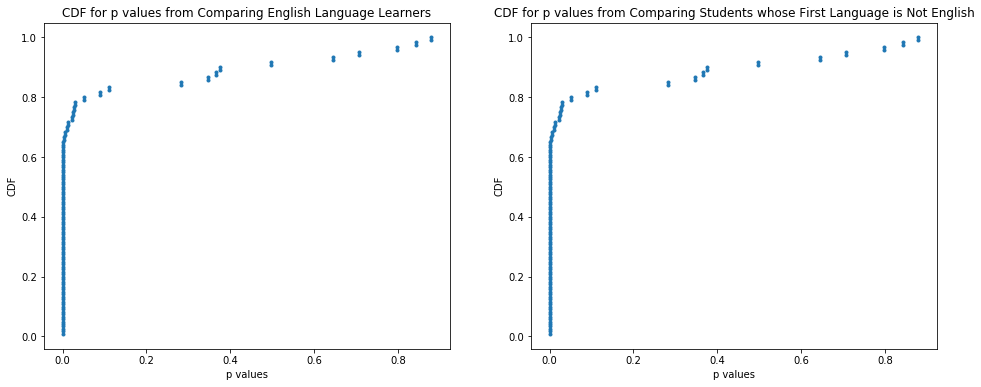

In [13]:
p_value, cdf = ecdf(school_ell_compare['ell_p_value'])

plt.figure(figsize=(16,6))
plt.subplot(121)
plt.plot(p_value, cdf, marker='.', linestyle='none')
plt.xlabel('p values')
plt.ylabel('CDF')
plt.title('CDF for p values from Comparing English Language Learners')
plt.subplot(122)
plt.plot(p_value, cdf, marker='.', linestyle='none')
plt.xlabel('p values')
plt.ylabel('CDF')
plt.title('CDF for p values from Comparing Students whose First Language is Not English')

Looking at these charts, it appears there is a larger proportion of zip codes with significantly different percentages. Below, we take a more exact look at this, and find that about 80% of zip codes have significantly different charter and public schools.

In [19]:
school_sigdif_ell = school_ell_compare[school_ell_compare['ell_p_value'] < 0.05]
school_sigdif_flne = school_ell_compare[school_ell_compare['flne_p_value'] < 0.05]

print("Proportion of significantly different zip codes:\nEnglish Language Learners: {:.2f} First Language Not English: {:.2f}".format(len(school_sigdif_ell)/len(school_ell_compare), len(school_sigdif_flne)/len(school_ell_compare)))

Proportion of significantly different zip codes:
English Language Learners: 0.78 First Language Not English: 0.80


In [15]:
prop_public_higher_ell  = school_sigdif_ell['higher_ell'].sum()/len(school_ell_compare)
prop_public_higher_flne = school_sigdif_flne['higher_flne'].sum()/len(school_ell_compare)

print("Proportion of Zip Codes where Public Schools have significantly higher %'s of English Language Learners: {:.3f}".format(prop_public_higher_ell))
print("Proportion of Zip Codes where Public Schools with significantly higher %'s of Students w/ First Language Not English: {:.3f}".format(prop_public_higher_flne))

Proportion of Zip Codes where Public Schools have significantly higher %'s of English Language Learners: 0.517
Proportion of Zip Codes where Public Schools with significantly higher %'s of Students w/ First Language Not English: 0.500


From these calculations, we see that amongst all zip codes with both charter and public schools public schools have a higher percentage of English language learners and students with first language not English about half of the time. This suggests public schools don't necessarily better serve these students.

In [16]:
print("Proportion amongst zip codes with significantly different schools where Public Schools have significantly higher %'s of \nEnglish Language Learners: {:.3f}, Students w/ First Language Not English: {:.3f}".format(school_sigdif_ell['higher_ell'].sum()/len(school_sigdif_ell), school_sigdif_flne['higher_flne'].sum()/len(school_sigdif_ell)))

Proportion amongst zip codes with significantly different schools where Public Schools have significantly higher %'s of 
English Language Learners: 0.660, Students w/ First Language Not English: 0.638


However, when just looking at zip codes where there is a significant difference, it appears that public schools tend to serve a higher percentage when there is a significant difference between the charter and public schools.

## Conclusions

1. There is a significant difference between the percentage of students who are English language learners or whose first language is not English.
2. There is not enough evidence to suggest that public schools serve more of these students. Also, this analysis doesn't go deep enough to analyze the services provided to these students and their efficacy.

For future work, I would want to go deeper into what/how many services the schools provide. I would also want to track how students who receive those services perform over their school careers.